In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

#sklearn 
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

# nlp preprocessing lib
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import string 
punctation = string.punctuation
 

**Loading the data**

In [2]:
Tweet_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

In [3]:
Tweet_d_copy= Tweet_df.copy()

In [4]:
Tweet_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
Tweet_df['keyword'].isna().sum()

61

In [6]:
Tweet_df = Tweet_df.drop(['id', 'keyword', 'location'], axis = 1)


In [7]:
Tweet_df.shape

(7613, 2)

In [8]:
Tweet_df.columns

Index(['text', 'target'], dtype='object')

In [9]:
Tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


In [10]:
Tweet_df[Tweet_df["target"] == 1]["text"].values[0]


'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [11]:
Tweet_df[Tweet_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

In [12]:
print("Number of duplicates in data : {}".format(len(Tweet_df[Tweet_df.duplicated()])))


Number of duplicates in data : 92


In [13]:
print("Duplicated rows before remove them : ")
Tweet_df[Tweet_df.duplicated(keep=False)].sort_values(by="text").head(8)

Duplicated rows before remove them : 


,text,target
4299,#Allah describes piling up #wealth thinking it...,0
4290,#Allah describes piling up #wealth thinking it...,0
6373,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6363,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6366,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6377,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6378,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6392,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1


In [14]:
#remove duplicated rows
Tweet_df.drop_duplicates(inplace=True)

In [15]:
print("Number of duplicates in data : {}".format(len(Tweet_df[Tweet_df.duplicated()])))


Number of duplicates in data : 0


In [16]:
Tweet_df['target'].value_counts()

0    4315
1    3206
Name: target, dtype: int64

Text(0.5, 0, 'Disaster Type')

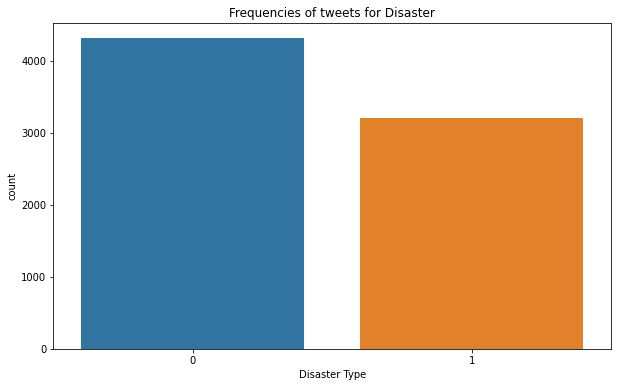

In [17]:
# count plot "Histogram" of Frequencies of Subjects for true news
plt.figure(figsize=(10,6))
plt.title("Frequencies of tweets for Disaster")
sns.countplot(x = 'target', data = Tweet_df)
plt.xlabel('Disaster Type')

In [18]:
Real_Disaster_df = Tweet_df[Tweet_df['target'] == 1]
Real_Disaster_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [19]:
Not_Real_Disaster_df = Tweet_df[Tweet_df['target'] == 0]
Not_Real_Disaster_df.head()

,text,target
15,What's up man?,0
16,I love fruits,0
17,Summer is lovely,0
18,My car is so fast,0
19,What a goooooooaaaaaal!!!!!!,0


## **Text Preprocessing**

In [20]:
# take text and preprocess 'remove stopwords [a, the, and, thus, ... etc] and punctations[,%$ ..etc] and len of text less than 3' 
def clean_text(text):
    """
        text: a string 
        return: cleaned string
    """
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and token not in punctation and  len(token) >= 3 :
            token = token.lower() 
            result.append(token)    
    return " ".join(result)

In [21]:
Tweet_df['text'] = Tweet_df['text'].map(clean_text)
Tweet_df.head()

,text,target
0,deeds reason earthquake allah forgive,1
1,forest near ronge sask canada,1
2,residents asked shelter place notified officer...,1
3,people receive wildfires evacuation orders cal...,1
4,got sent photo ruby alaska smoke wildfires pou...,1


In [22]:
from sklearn.utils import shuffle
Tweet_df_shuffled = shuffle(Tweet_df)
Tweet_df_shuffled.head()

,text,target
61,progressive greetings month students set pens ...,0
1751,baltimore city north fort mchenry tunnel bore ...,1
7515,malaysia confirms wreckage belongs http kacrlp...,1
6950,crptotech tsunami banks http khztevedja bankin...,1
6034,kakajambori control future india yor subject e...,0


## **split Dataset**

In [23]:
X = Tweet_df_shuffled['text']
y = Tweet_df_shuffled['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify = y)

## Text-Representations - TF-IDF

In [24]:
from sklearn.model_selection import cross_val_score
nb_classifier = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),])

nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)
print('accuracy {}'.format(accuracy_score(y_pred, y_test)))

accuracy 0.7946843853820598


In [25]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='epsilon_insensitive', penalty='l2',alpha=1e-3, random_state=42, max_iter=1000, tol=None)),])


sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
print('accuracy {}'.format(accuracy_score(y_pred, y_test)))

accuracy 0.770764119601329


## **Another solution**

In [26]:
Tweet_d_copy.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [27]:
Tweet_d_copy['keyword'].isna().sum()

61

In [28]:
# As a test, I'll fill the NA for the keyword column with 'neutral'
Tweet_d_copy['keyword'].fillna('neutral', inplace = True)

In [29]:
# I wont use the location column so I will drop it
Tweet_d_copy.drop(['location', 'id'], inplace = True, axis =1)

In [30]:
X =  Tweet_d_copy[['keyword', 'text']]
y = Tweet_d_copy.target.values

# Train test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 11)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6851, 2), (762, 2), (6851,), (762,))

## **Keras model with word embeddings**

In [31]:
import spacy
import cupy
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import classification_report

In [32]:
# Need to load the large model to get the vectors
nlp = spacy.load('en_core_web_lg')

## **Function for making the embeddings**

In [33]:
def make_embedding(texts):

    with nlp.disable_pipes():
        embeddings = [cupy.asnumpy(nlp(text).vector) for text in texts]
        embeddings = np.array(embeddings)
        
        return embeddings

In [34]:
# make the embeddings on the train data and process it
def process_train(train):
    train = make_embedding(train)
    
    mean = train.mean(axis = 0)
    train = train - mean
    
    scaler = StandardScaler()
    scaler.fit(train)
    
    train = scaler.transform(train)
    
    return scaler,mean, train

In [35]:
txt_scaler, txt_mean, train_txt= process_train(X_train.text.values)
kw_scaler, kw_mean, train_kw = process_train(X_train.keyword.values)

train_data = np.array(list(zip(train_txt,train_kw)))

In [36]:
def process_texts( scaler, texts, mean):
    # Create the text embedding
    texts = make_embedding(texts)
    
    # Center the embedding by substracting the mean of the train data
    texts = texts - mean
    
    # Scale the data with sklearn's standardScaler fitted on the train data
    texts = scaler.transform(texts)
    
    return texts

In [37]:
val_txt = process_texts( txt_scaler, X_test.text.values, txt_mean)
val_kw = process_texts( kw_scaler, X_test.keyword.values, kw_mean)

val_data = np.array(list(zip(val_txt,val_kw)))
val_data.shape

(762, 2, 300)

In [38]:
keras_clf = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(2, 300)),
    tf.keras.layers.Dropout(0.2),
   # tf.keras.layers.Dense(300, activation='relu'),
   # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(2, activation="softmax")
])

keras_clf.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

2021-12-12 14:41:09.255401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 14:41:09.256803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 14:41:09.257458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 14:41:09.258291: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [39]:
def keras_model_predict(texts):
    preds = keras_clf.predict(texts)
    preds = [a.argmax() for a in preds]
    
    return preds

In [40]:
keras_train_preds = keras_model_predict(train_data)
print(classification_report(y_train, keras_train_preds, target_names=['not_disaster', 'disaster']))

2021-12-12 14:41:17.186324: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


              precision    recall  f1-score   support

not_disaster       0.63      0.03      0.05      3904
    disaster       0.43      0.98      0.60      2947

    accuracy                           0.44      6851
   macro avg       0.53      0.50      0.33      6851
weighted avg       0.55      0.44      0.29      6851

